In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_' + metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_' + metric])

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Metal device set to: Apple M1 Pro


2022-07-16 11:31:23.681575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-16 11:31:23.681835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2022-07-16 11:31:32.370586: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-16 11:31:32.393451: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'As a lover of the surreal (in art and film) I was pleased to discover this film on IFC. It is definitely a keeper. Most of the other reviews tell the general plot (not all correct) so I won\'t bother to bore anyone with that. The main thing is the alternate worlds concept which is brought on by Ana\'s impending illness, and the way she manages to link with someone else after being so "alone", and finally with her family, which I believe is still at least a little troubled. It only can be called a horror movie in that it has frightening scenes but is a fantasy (with a little hint of "coming of age" only because Ana is a pre-teen who "hates boys"). I heartily recommend it to those who appreciate the stretch of their imagination.'
 b'I would have liked to give this movie a zero but that wasn\'t an option!! This movie sucks!!! The women cannot act. i should have known it was gonna suck when i saw Bobby Brown. Nobody in my house could believe i hadn\'t changed the channel after t

2022-07-16 11:31:36.166195: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

2022-07-16 11:31:36.801740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,   4,   1, ...,   0,   0,   0],
       [ 10,  59,  26, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'As a lover of the surreal (in art and film) I was pleased to discover this film on IFC. It is definitely a keeper. Most of the other reviews tell the general plot (not all correct) so I won\'t bother to bore anyone with that. The main thing is the alternate worlds concept which is brought on by Ana\'s impending illness, and the way she manages to link with someone else after being so "alone", and finally with her family, which I believe is still at least a little troubled. It only can be called a horror movie in that it has frightening scenes but is a fantasy (with a little hint of "coming of age" only because Ana is a pre-teen who "hates boys"). I heartily recommend it to those who appreciate the stretch of their imagination.'
Round-trip:  as a [UNK] of the [UNK] in art and film i was [UNK] to [UNK] this film on [UNK] it is definitely a [UNK] most of the other reviews tell the general plot not all [UNK] so i wont [UNK] to [UNK] anyone with that the main thing is the [UNK]

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2022-07-16 11:31:45.146337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-16 11:31:45.392630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-16 11:31:45.431737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
[0.01980087]


In [18]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 11s 11s/step
[0.03091987]


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [20]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [22]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [23]:
history = None

with tf.device('/GPU:0'):
    history = model.fit(train_dataset, epochs=10,
                        validation_data=test_dataset,
                        validation_steps=30)

Epoch 1/10


2022-07-16 11:32:09.720906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-16 11:32:10.187404: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2022-07-16 11:32:10.190627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-16 11:32:10.290456: I tensorflow/co

 10/391 [..............................] - ETA: 1:05:23 - loss: 0.6946 - accuracy: 0.4813

KeyboardInterrupt: 

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 73s 186ms/step - loss: 0.3242 - accuracy: 0.8544
Test Loss: 0.3241698145866394
Test Accuracy: 0.8543999791145325


(0.0, 0.6609700500965119)

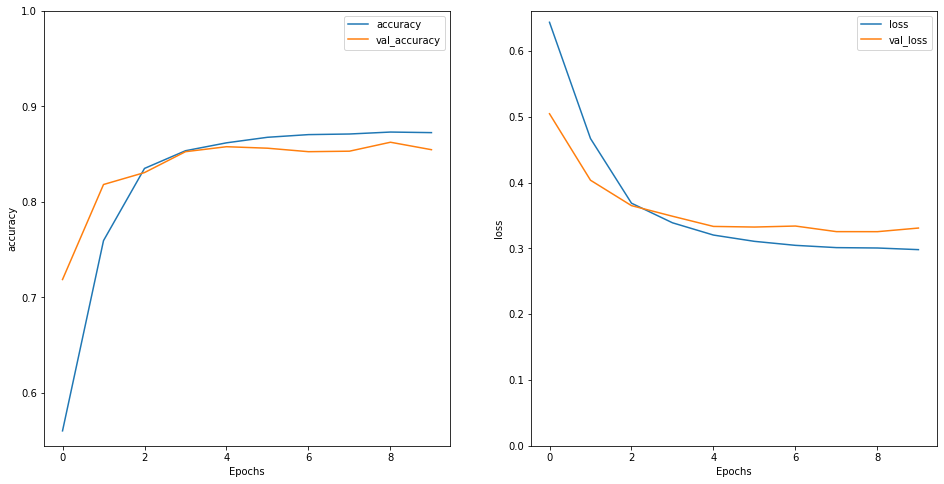

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [23]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 1s 998ms/step


In [25]:
predictions

array([[0.74662054]], dtype=float32)

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 426s 1s/step - loss: 0.6321 - accuracy: 0.5738 - val_loss: 0.4572 - val_accuracy: 0.8062
Epoch 2/10
391/391 [==============================] - 437s 1s/step - loss: 0.3917 - accuracy: 0.8274 - val_loss: 0.3518 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 868s 2s/step - loss: 0.3361 - accuracy: 0.8568 - val_loss: 0.3357 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 411s 1s/step - loss: 0.3209 - accuracy: 0.8642 - val_loss: 0.3244 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 416s 1s/step - loss: 0.3105 - accuracy: 0.8684 - val_loss: 0.3268 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 426s 1s/step - loss: 0.3084 - accuracy: 0.8689 - val_loss: 0.3217 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 434s 1s/step - loss: 0.3048 - accuracy: 0.8690 - val_loss: 0.3231 - val_accuracy: 0.8432

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 109s 278ms/step - loss: 0.3217 - accuracy: 0.8468
Test Loss: 0.3216763734817505
Test Accuracy: 0.8467599749565125


In [30]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[-1.8079299]]


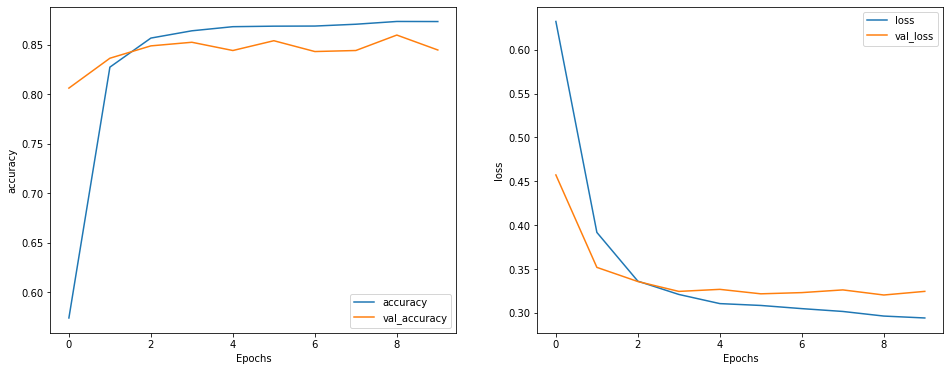

In [31]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')